In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
import scipy.stats as stats
from scipy.stats import gaussian_kde
from sklearn.preprocessing import scale
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
penguins = pd.read_csv("../data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]
penguins.shape

(333, 8)

In [4]:
coords = {"species": ["Adelie", "Gentoo", "Chinstrap"]}

with pm.Model(coords=coords) as hierarchical_model:
    # Constant data for species indices
    species_idx = pm.ConstantData(
        "species_idx",
        penguins["species"].replace({"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}).values,
    )

    # Hyperpriors
    mu_mean = pm.Normal("mu_mean", 4200, 1000)
    mu_sd = pm.HalfNormal("mu_sd", 500)
    sigma_mean = pm.HalfNormal("sigma_mean", 500)
    sigma_sd = pm.HalfNormal("sigma_sd", 100)
    
    # Normal priors for mu and sigma for each species
    mu = pm.Normal("mu", mu_mean, mu_sd, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=sigma_mean, dims="species")

    # Likelihood
    y = pm.Normal(
        "y",
        mu=mu[species_idx],
        sigma=sigma[species_idx],
        observed=penguins["body_mass_g"],
    )

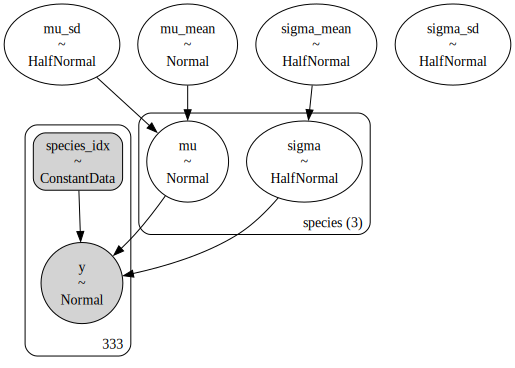

In [5]:
pm.model_to_graphviz(hierarchical_model)

In [6]:
with hierarchical_model:
    idata_pooling_prior_pred = pm.sample_prior_predictive(random_seed=rng)

Sampling: [mu, mu_mean, mu_sd, sigma, sigma_mean, sigma_sd, y]


In [7]:
likelihood_samples = idata_pooling_prior_pred.prior_predictive.y
flattened_array = np.ravel(likelihood_samples.values)

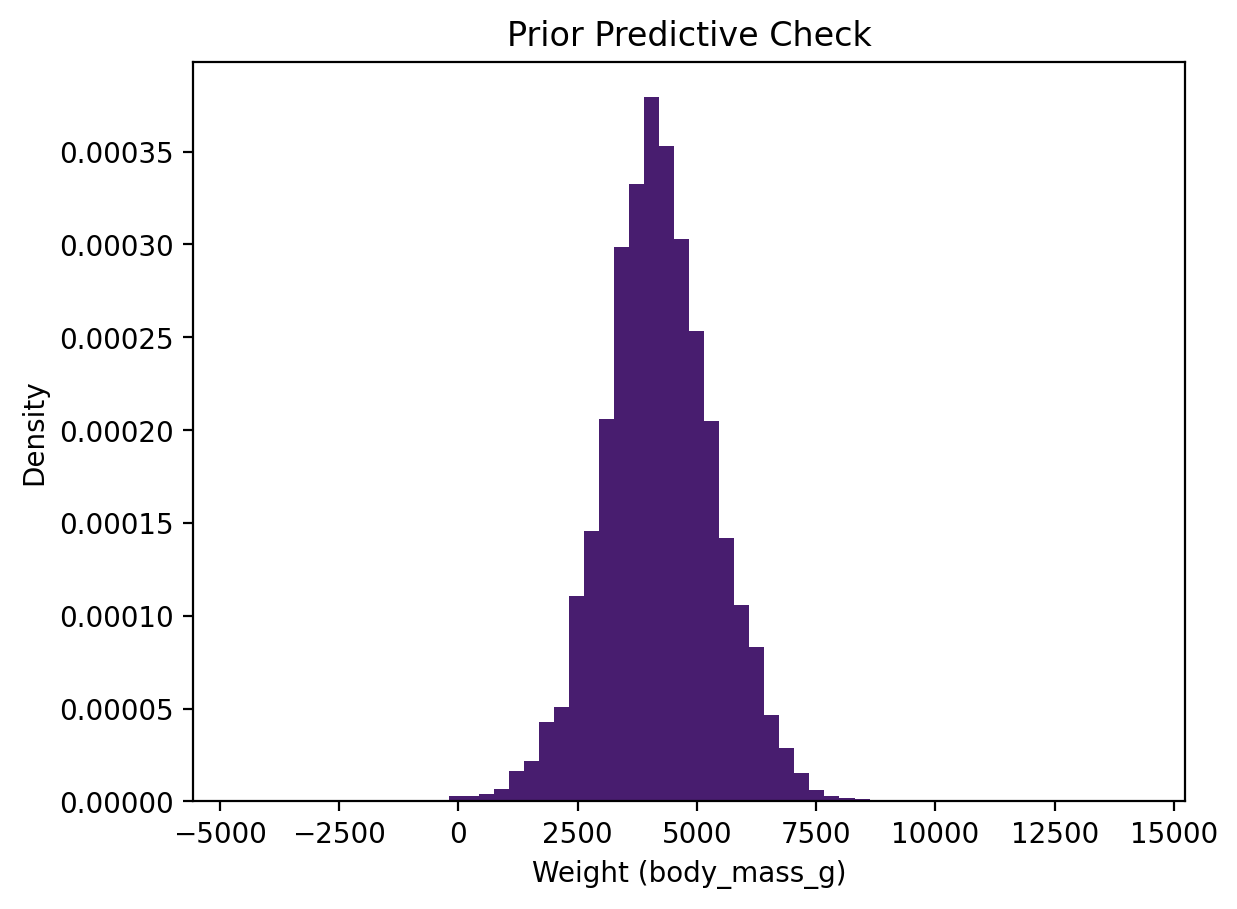

In [8]:
plt.hist(flattened_array, bins=60, density=True)
plt.xlabel('Weight (body_mass_g)')
plt.ylabel('Density')
plt.title('Prior Predictive Check')
plt.show()

In [9]:
with hierarchical_model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time =  0:00:03.286322
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:02.726243
Transforming variables...
Transformation time =  0:00:00.026177
Computing Log Likelihood...


Log Likelihood time =  0:00:00.236651


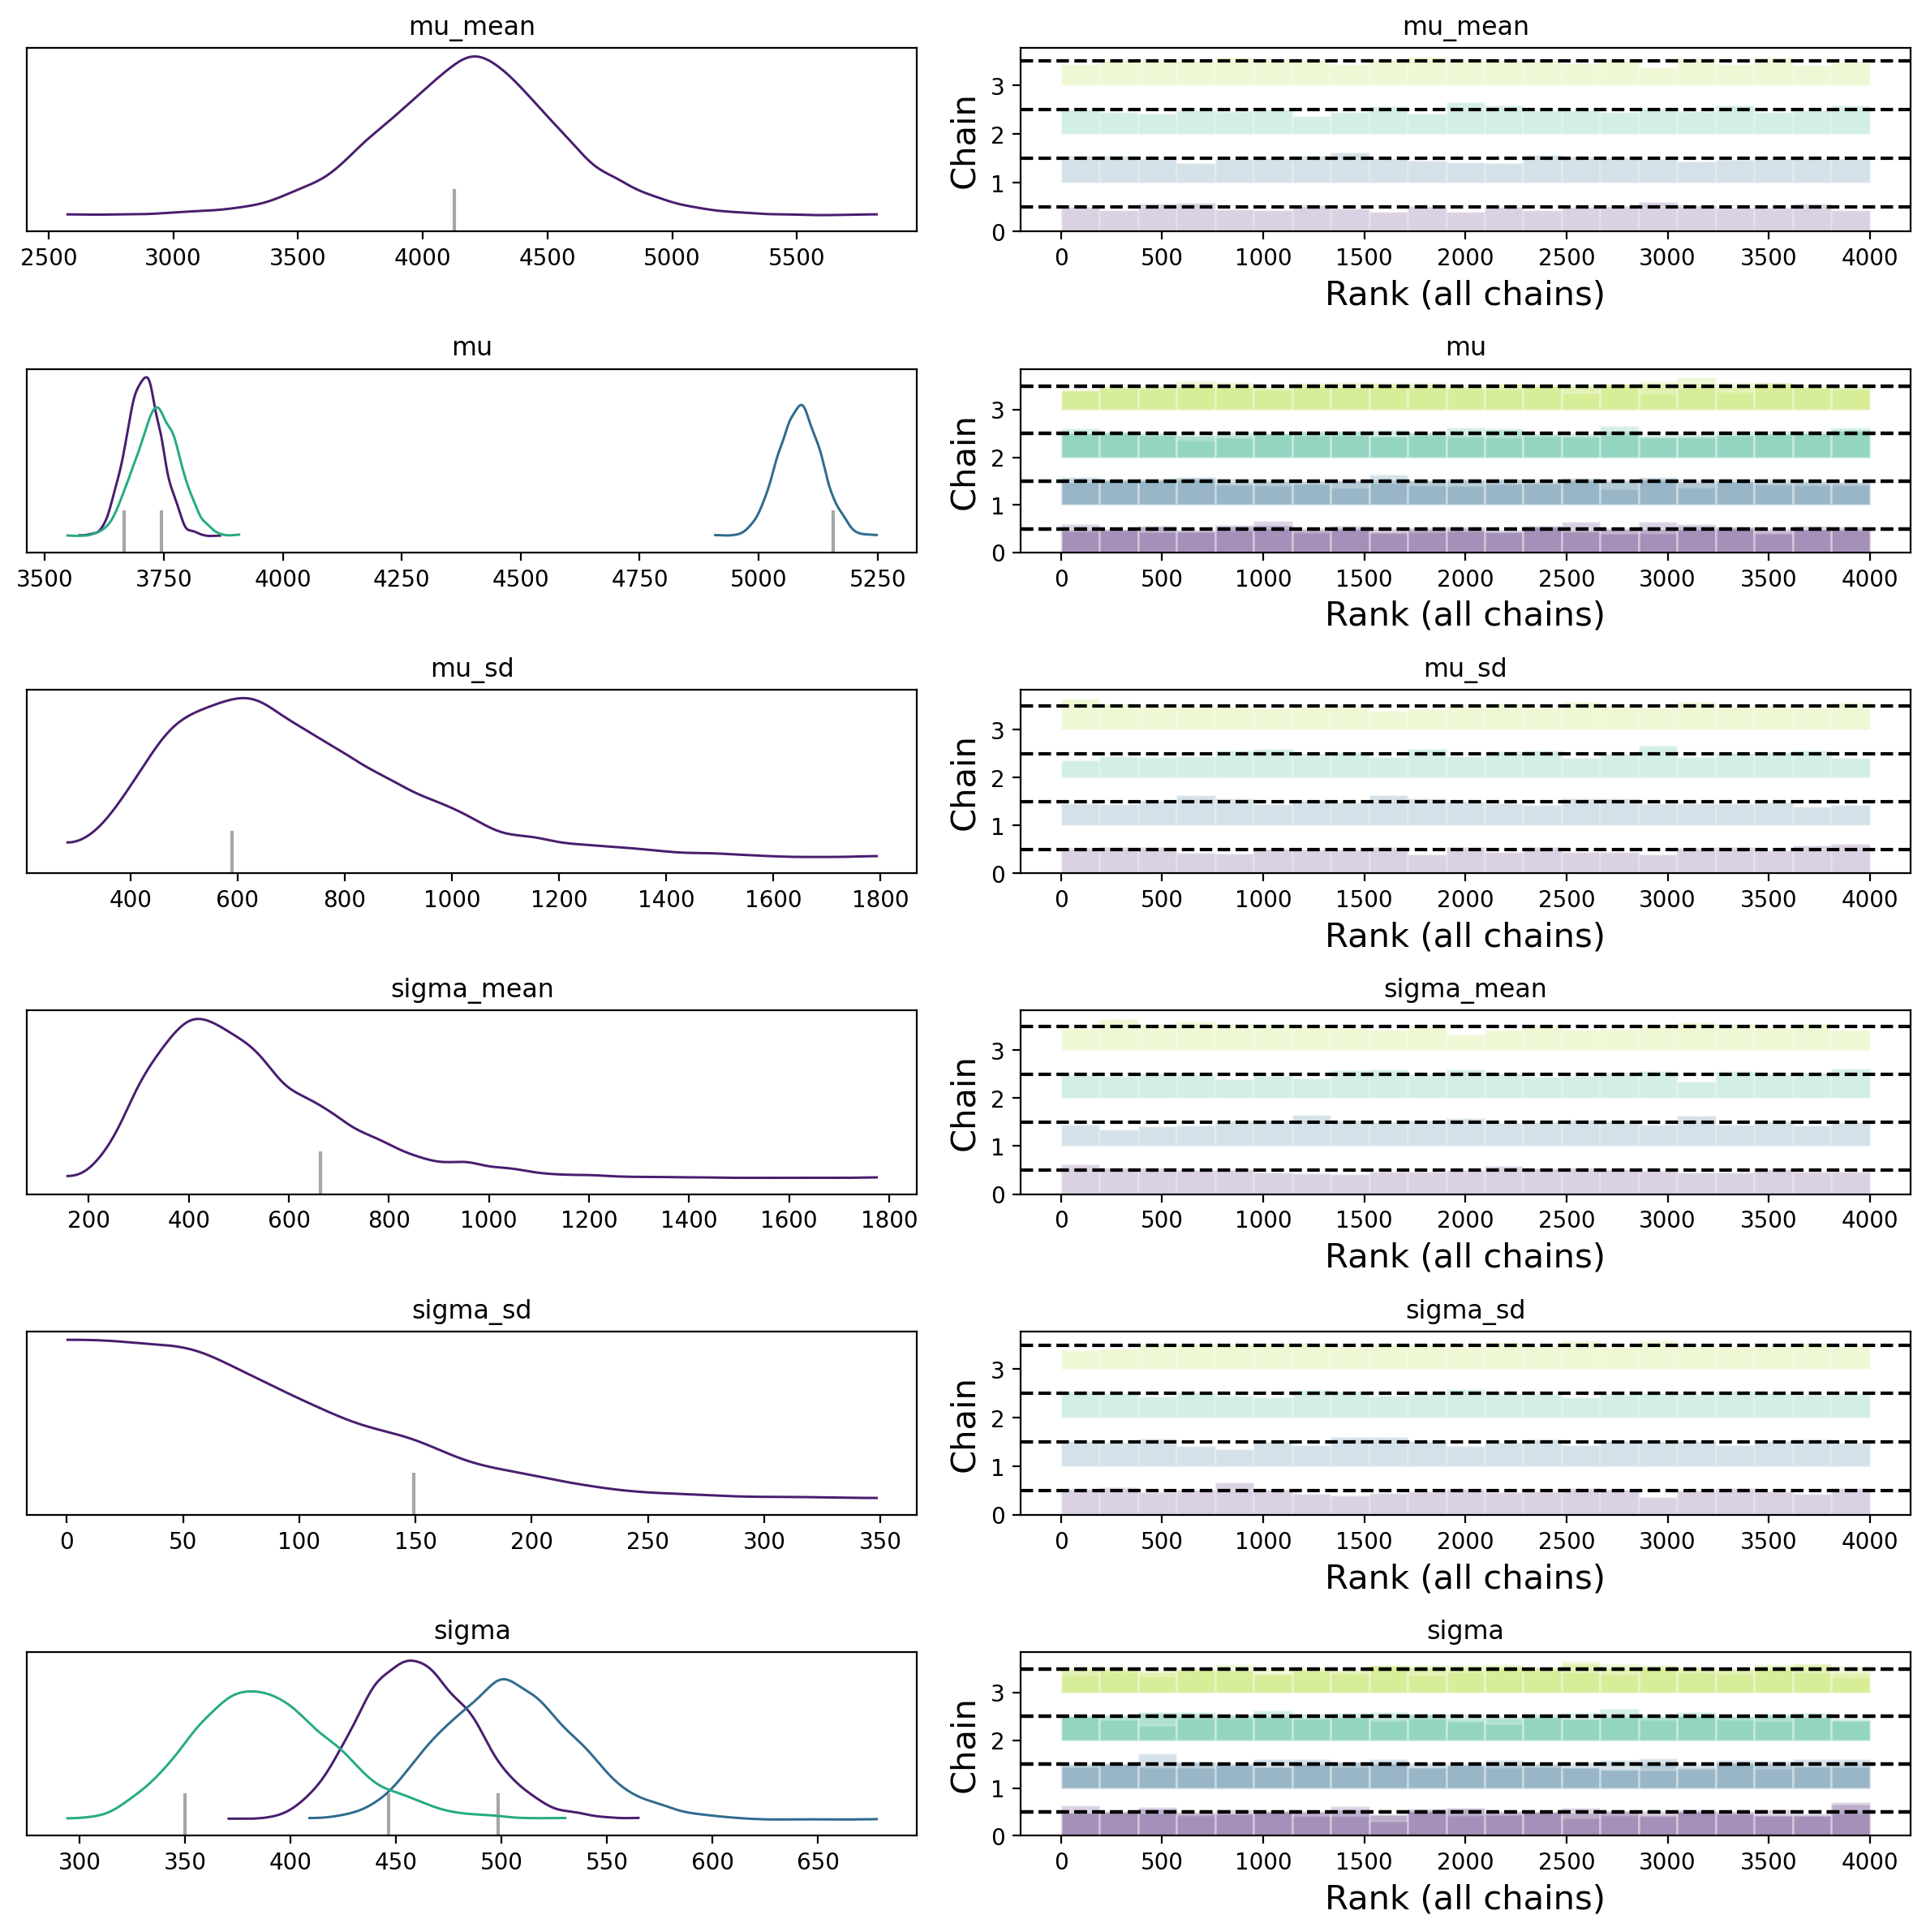

In [10]:
az.plot_trace(idata, combined=True, kind="rank_bars")
plt.tight_layout()
plt.show()

In [11]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_mean,4179.011,377.319,3487.535,4920.087,6.609,4.678,3407.0,2501.0,1.0
mu[Adelie],3708.371,37.442,3637.692,3776.463,0.573,0.406,4281.0,2792.0,1.0
mu[Gentoo],5085.806,46.100,5004.072,5176.085,0.663,0.469,4755.0,2731.0,1.0
mu[Chinstrap],3736.699,47.196,3647.703,3822.388,0.701,0.496,4542.0,2806.0,1.0
mu_sd,699.916,223.892,322.029,1111.346,3.729,2.734,3623.0,2983.0,1.0
sigma_mean,520.829,187.723,214.935,858.510,2.914,2.214,4838.0,3052.0,1.0
sigma_sd,79.584,59.177,0.011,186.351,0.867,0.613,3201.0,1948.0,1.0
sigma[Adelie],460.902,27.197,409.817,510.290,0.366,0.261,5625.0,3112.0,1.0
sigma[Gentoo],504.141,32.389,442.196,562.719,0.462,0.330,4972.0,3078.0,1.0
sigma[Chinstrap],389.404,34.945,326.168,455.544,0.513,0.373,5050.0,2410.0,1.0


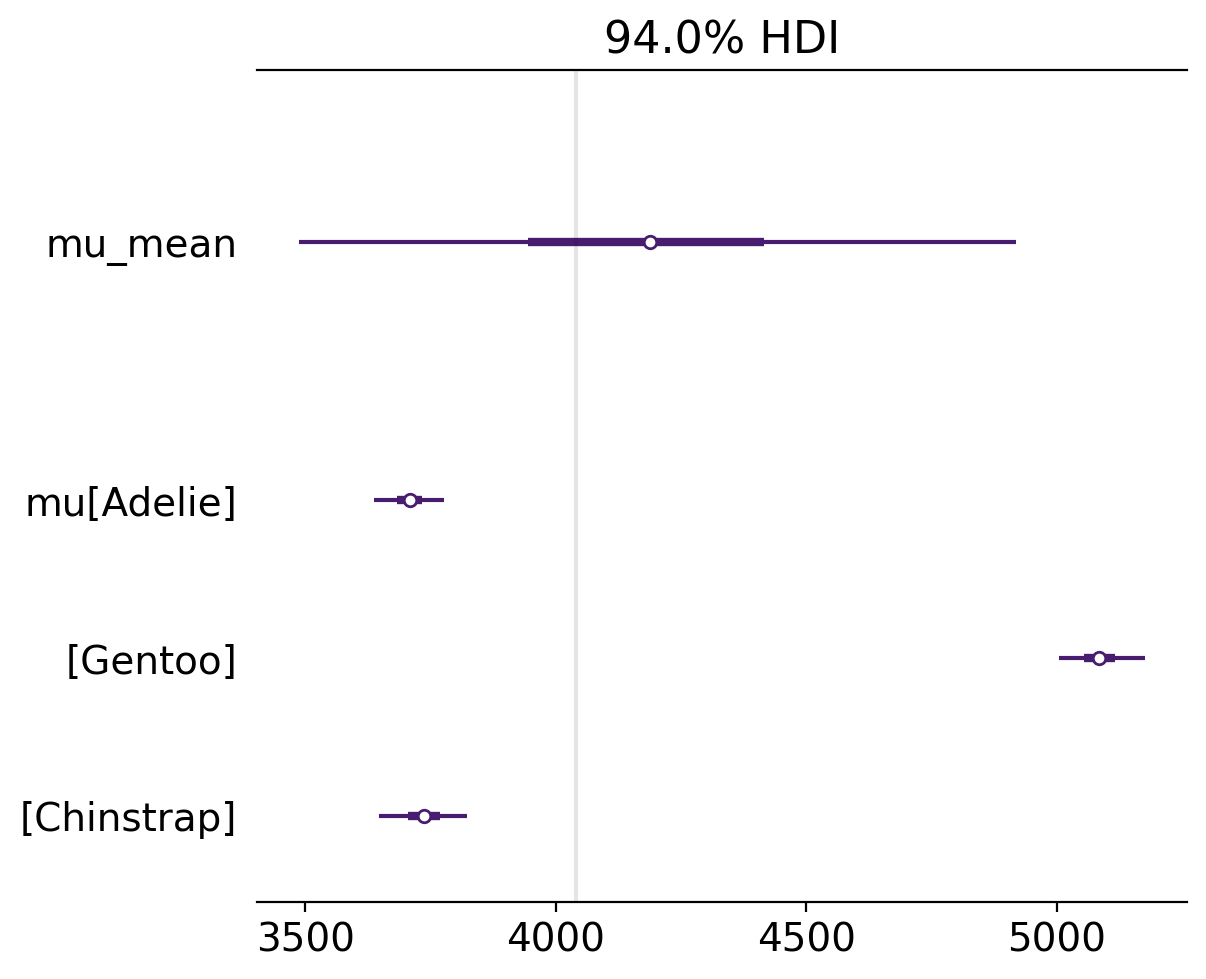

In [12]:
var_names=["mu_mean", "mu"]
az.plot_forest(idata, var_names=var_names, combined=True)
obs_mean=hierarchical_model["y"].eval().mean()
plt.axvline(x = obs_mean, color = 'black', alpha=0.1)
plt.show()

In [13]:
with hierarchical_model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [y]


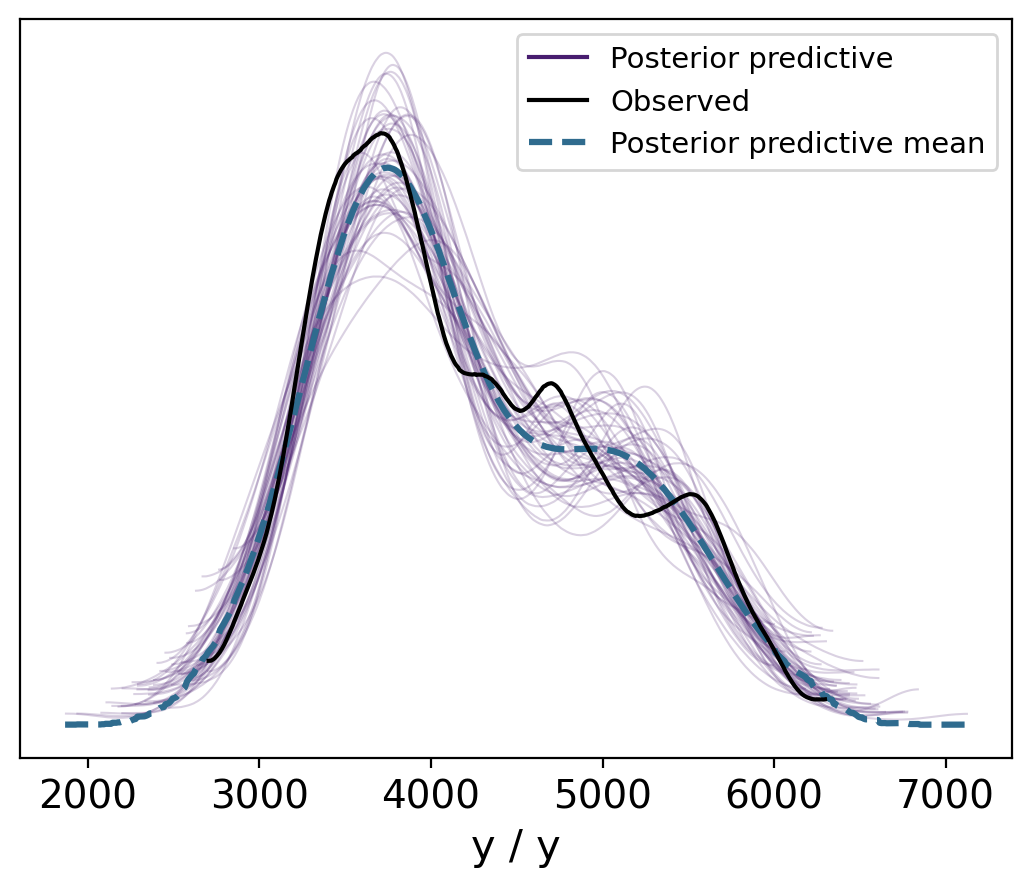

In [14]:
az.plot_ppc(post_pred, num_pp_samples=50)
plt.show()

In [15]:
m_loo = az.loo(idata)
m_loo

Computed from 4000 posterior samples and 333 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2516.18    11.71
p_loo        5.52        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      333  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pytensor: 2.12.3

arviz     : 0.16.0
bambi     : 0.12.0
scipy     : 1.10.1
matplotlib: 3.7.2
pymc      : 5.6.1
pandas    : 2.0.3
numpy     : 1.25.2
seaborn   : 0.12.2

Watermark: 2.4.3

